## 1622 Final Project

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from os import path
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
import scipy.stats as scs
import cvxpy as cp
import cplex
import statsmodels.api as smf

## Question 1 Part 1

In [2]:
# Read Daily Prices
# CSV file with price data
input_file_prices  = 'Daily_closing_prices.csv'
# Read data into a dataframe
df = pd.read_csv(input_file_prices)
# Create a dataframe with only MSFT, AAPL, IBM
df1 = df[['MSFT','AAPL','IBM']]
df1

,MSFT,AAPL,IBM
0,98.602066,38.562561,104.458885
1,94.974693,34.721451,102.373520
2,99.391899,36.203678,106.371994
3,99.518669,36.123104,107.124527
4,100.240234,36.811718,108.647758
...,...,...,...
500,222.750000,131.970001,124.690002
501,224.960007,136.690002,124.820000
502,224.149994,134.869995,123.800003
503,221.679993,133.720001,124.339996


### Daily Loss for Each Stock

In [3]:
# Calculate the difference between rows - By default, periods = 1
difference = df1.diff(axis=0).iloc[1:]
print("Difference between rows (Period=1):")
difference

Difference between rows (Period=1):


,MSFT,AAPL,IBM
1,-3.627373,-3.841110,-2.085365
2,4.417206,1.482227,3.998474
3,0.126770,-0.080574,0.752533
4,0.721565,0.688614,1.523231
5,1.433388,0.625126,0.779755
...,...,...,...
500,1.729996,1.009995,0.790001
501,2.210007,4.720001,0.129997
502,-0.810013,-1.820007,-1.019997
503,-2.470001,-1.149994,0.539993


### Daily Loss for Portfolio

In [4]:
# Profit/Loss (P/L) data
PLData=100*difference['MSFT']+200*difference['AAPL']+500*difference['IBM']


# Number of historical scenarios
N=len(PLData)
N

504

### 10-Day Loss for Each Stock

In [5]:
# Calculate the difference between rows - periods = 10
difference_10 = df1.diff(periods=10).iloc[10:]
print("Difference between rows (Period=10):")
difference_10

Difference between rows (Period=10):


,MSFT,AAPL,IBM
10,4.153931,-0.727680,5.811836
11,8.502884,3.338085,8.414017
12,5.636078,2.090271,5.893425
13,3.529846,1.311306,3.962204
14,3.812637,0.774086,11.841278
...,...,...,...
500,12.229996,8.730003,-0.269997
501,11.700012,14.279999,0.550003
502,9.949997,13.089996,0.270004
503,7.549988,5.840004,-1.590004


### 10-Day Loss for Portfolio

In [6]:
# Profit/Loss (P/L) data
PLData_10=100*difference_10['MSFT']+200*difference_10['AAPL']+500*difference_10['IBM']

# Number of historical scenarios
N10=len(PLData_10)
N10

495

In [7]:
# Specify quantile level for VaR/CVaR
alf = 0.95
# Sort 1-day loss data in increasing order
loss_1d = np.sort(-PLData)
# Sort 10-day loss data in increasing order
loss_10d = np.sort(-PLData_10)

In [8]:
# Compute Historical 1-day VaR from the data
VaR1 = loss_1d[int(math.ceil(N * alf)) - 1]
# Compute Historical 1-day CVaR from the data
CVaR1 = (1 / (N * (1 - alf))) * ((math.ceil(N * alf) - N * alf) * VaR1 + sum(loss_1d[int(math.ceil(N * alf)):]))
# Compute Normal 1-day VaR from the data
VaR1n = np.mean(loss_1d) + scs.norm.ppf(alf) * np.std(loss_1d)
# Compute Normal 1-day CVaR from the data
CVaR1n = np.mean(loss_1d) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(loss_1d)

# Compute Historical 10-day VaR from the data
VaR10 = loss_10d[int(math.ceil(N10 * alf)) - 1]
# Compute Historical 10-day CVaR from the data
CVaR10 = (1 / (N10 * (1 - alf))) * ((math.ceil(N10 * alf) - N10 * alf) * VaR10 + sum(loss_10d[int(math.ceil(N10 * alf)):]))
# Compute Normal 10-day VaR from the data
VaR10n = np.mean(loss_10d) + scs.norm.ppf(alf) * np.std(loss_10d)
# Compute Normal 10-day CVaR from the data
CVaR10n = np.mean(loss_10d) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(loss_10d)

print('Historical 1-day VaR %4.1f%% = $%6.2f,   Historical 1-day CVaR %4.1f%% = $%6.2f\n'% (100*alf, VaR1, 100*alf, CVaR1))
print('    Normal 1-day VaR %4.1f%% = $%6.2f,       Normal 1-day CVaR %4.1f%% = $%6.2f\n'% (100*alf, VaR1n, 100*alf, CVaR1n))
print('Historical 10-day VaR %4.1f%% = $%6.2f,   Historical 10-day CVaR %4.1f%% = $%6.2f\n'% (100*alf, VaR10, 100*alf, CVaR10))
print('    Normal 10-day VaR %4.1f%% = $%6.2f,       Normal 10-day CVaR %4.1f%% = $%6.2f\n'% (100*alf, VaR10n, 100*alf, CVaR10n))

Historical 1-day VaR 95.0% = $2477.25,   Historical 1-day CVaR 95.0% = $4326.98

    Normal 1-day VaR 95.0% = $2646.49,       Normal 1-day CVaR 95.0% = $3339.94

Historical 10-day VaR 95.0% = $9023.03,   Historical 10-day CVaR 95.0% = $14099.34

    Normal 10-day VaR 95.0% = $7331.15,       Normal 10-day CVaR 95.0% = $9396.60



### Plot a histogram of the distribution of losses in portfolio value

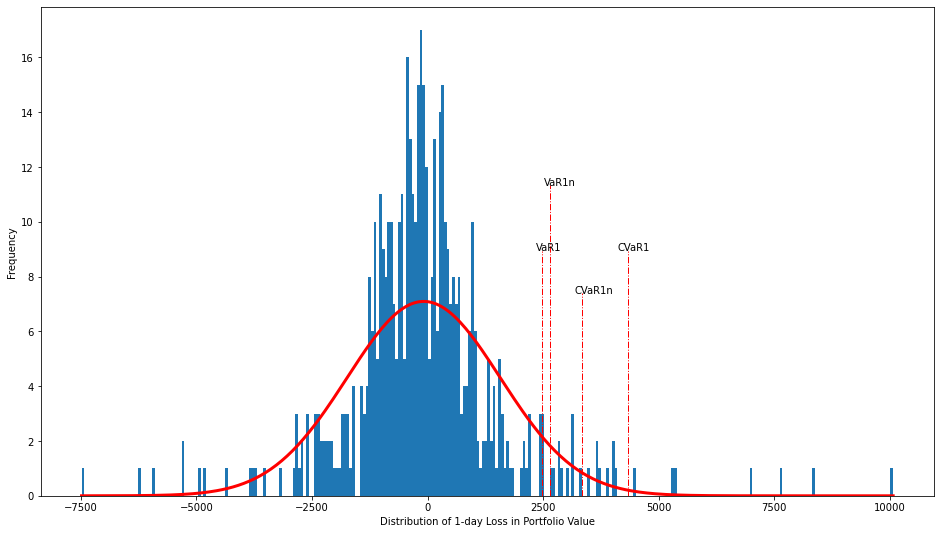

In [9]:
plt.figure(figsize=(16,9))
frequencyCounts, binLocations, patches = plt.hist(loss_1d, 300)
normf = (1 / (np.std(loss_1d) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(loss_1d)) / np.std(loss_1d)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.plot([VaR1, VaR1], [0, max(frequencyCounts) / 1.9], color='r', linewidth=1, linestyle='-.')
plt.plot([VaR1n, VaR1n], [0, max(frequencyCounts)/ 1.5], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaR1, CVaR1], [0, max(frequencyCounts) / 1.9], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaR1n, CVaR1n], [0, max(frequencyCounts) / 2.3], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaR1, max(frequencyCounts) / 1.9, 'VaR1')
plt.text(0.95 * VaR1n, max(frequencyCounts) / 1.5, 'VaR1n')
plt.text(0.95 * CVaR1, max(frequencyCounts) / 1.9, 'CVaR1')
plt.text(0.95 * CVaR1n, max(frequencyCounts) / 2.3, 'CVaR1n')

plt.xlabel('Distribution of 1-day Loss in Portfolio Value')
plt.ylabel('Frequency')
plt.draw()

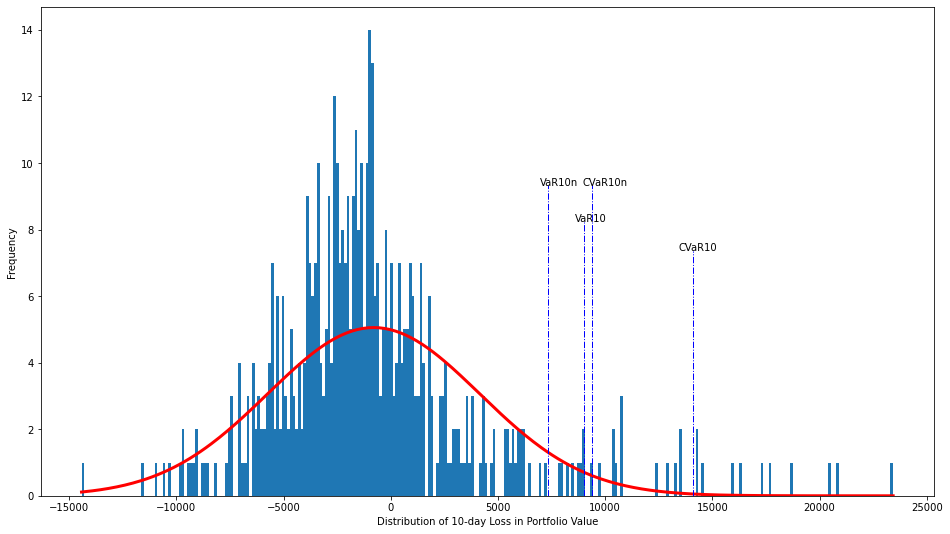

In [10]:
plt.figure(figsize=(16,9))
frequencyCounts, binLocations, patches = plt.hist(loss_10d, 300)
normf = (1 / (np.std(loss_10d) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(loss_10d)) / np.std(loss_10d)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.plot([VaR10, VaR10], [0, max(frequencyCounts) / 1.7], color='b', linewidth=1, linestyle='-.')
plt.plot([VaR10n, VaR10n], [0, max(frequencyCounts) / 1.5], color='b', linewidth=1, linestyle='-.')
plt.plot([CVaR10, CVaR10], [0, max(frequencyCounts) / 1.9], color='b', linewidth=1, linestyle='-.')
plt.plot([CVaR10n, CVaR10n], [0, max(frequencyCounts) / 1.5], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * VaR10, max(frequencyCounts) / 1.7, 'VaR10')
plt.text(0.95 * VaR10n, max(frequencyCounts) / 1.5, 'VaR10n')
plt.text(0.95 * CVaR10, max(frequencyCounts) / 1.9, 'CVaR10')
plt.text(0.95 * CVaR10n, max(frequencyCounts) / 1.5, 'CVaR10n')

plt.xlabel('Distribution of 10-day Loss in Portfolio Value')
plt.ylabel('Frequency')
plt.draw()

VaR(10-day) does not equal to 10xVaR(1-day)

CVaR(10-day) does not equal to 10xCVaR (1-day)

In [11]:
print('VaR for 10-day loss:', VaR10, '\nVaR for 1-day loss: ', VaR1)
print('CVaR for 10-day loss:', CVaR10, '\nCVaR for 1-day loss: ',CVaR1)

VaR for 10-day loss: 9023.029310000004 
VaR for 1-day loss:  2477.252192000003
CVaR for 10-day loss: 14099.341740868671 
CVaR for 1-day loss:  4326.981496960318


In [12]:
print('VaR for 1-day loss x sqrt(10):', VaR1*np.sqrt(10))
print('CVaR for 1-day loss x sqrt(10):', CVaR1*np.sqrt(10))

VaR for 1-day loss x sqrt(10): 7833.759265364759
CVaR for 1-day loss x sqrt(10): 13683.116923799545


## Question 1 Part 2

### Daily Loss for Each Stock

In [13]:
difference

,MSFT,AAPL,IBM
1,-3.627373,-3.841110,-2.085365
2,4.417206,1.482227,3.998474
3,0.126770,-0.080574,0.752533
4,0.721565,0.688614,1.523231
5,1.433388,0.625126,0.779755
...,...,...,...
500,1.729996,1.009995,0.790001
501,2.210007,4.720001,0.129997
502,-0.810013,-1.820007,-1.019997
503,-2.470001,-1.149994,0.539993


### Daily Loss for 100 MSFT,  200 AAPL and 500 IBM stocks

In [14]:
# Profit/Loss (P/L) data
PLData_MSFT=100*difference['MSFT']
PLData_AAPL=200*difference['AAPL']
PLData_IBM=500*difference['IBM']

# Number of historical scenarios
N_m, N_a, N_i = len(PLData_MSFT), len(PLData_AAPL), len(PLData_IBM)

In [15]:
# Specify quantile level for VaR/CVaR
alf = 0.95
# Sort 1-day loss data in increasing order
loss_m = np.sort(-PLData_MSFT)
loss_a = np.sort(-PLData_AAPL)
loss_i = np.sort(-PLData_IBM)

### Historical Scenario

In [16]:
# Compute Historical 1-day VaR for 100 MSFT
VaR_m = loss_m[int(math.ceil(N_m * alf)) - 1]
# Compute Historical 1-day VaR for 200 AAPL
VaR_a = loss_a[int(math.ceil(N_a * alf)) - 1]
# Compute Historical 1-day VaR for 500 IBM
VaR_i = loss_i[int(math.ceil(N_i * alf)) - 1]

### Compute VaR(portfolio) vs VaR(MSFT)+VaR(AAPL)+VaR(IBM)

In [17]:
print(VaR1 == VaR_m + VaR_a + VaR_i)
print('Sum of VaR of individual stocks:', VaR_m + VaR_a + VaR_i)
print('VaR of portfolio:', VaR1)
VaR1-(VaR_m + VaR_a + VaR_i)

False
Sum of VaR of individual stocks: 2933.5838380000023
VaR of portfolio: 2477.252192000003


-456.3316459999992

### Normal Distribution Model

In [18]:
# Compute Normal 1-day VaR for 100 MSFT
VaRn_m = np.mean(loss_m) + scs.norm.ppf(alf) * np.std(loss_m)
# Compute Normal 1-day VaR for 200 AAPL
VaRn_a = np.mean(loss_a) + scs.norm.ppf(alf) * np.std(loss_a)
# Compute Normal 1-day VaR for 500 IBM
VaRn_i = np.mean(loss_i) + scs.norm.ppf(alf) * np.std(loss_i)

### Compute VaRn(portfolio) vs VaRn(MSFT)+VaRn(AAPL)+VaRn(IBM)

In [19]:
print(VaR1n == VaRn_m + VaRn_a + VaRn_i)
print('Sum of VaR of individual stocks:', VaRn_m + VaRn_a + VaRn_i)
print('VaR of portfolio:', VaR1n)
VaR1n-(VaRn_m + VaRn_a + VaRn_i)

False
Sum of VaR of individual stocks: 3085.1433788349605
VaR of portfolio: 2646.4918309374666


-438.65154789749386

## Question 2 Part 1

In [20]:
if path.exists(input_file_prices):
    print('\nReading daily prices datafile - {}\n'.format(input_file_prices))
    fid = pd.read_csv(input_file_prices)
    # instrument tickers
    tickers = list(fid.columns)[1:]
    # time periods
    dates = fid['Date']
    data_prices = fid.values[:,1:]
else:
    print("No such file '{}'".format(input_file_prices), file=sys.stderr)
    
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(fid['Date'].apply(convert_date_to_array)))

# Number of assets in universe
Na = data_prices.shape[1]

# Number of historical scenarios
Ns = data_prices.shape[0]


Reading daily prices datafile - Daily_closing_prices.csv



### Expected Returns and Covariances

In [21]:
# Annual risk-free rate for years 2019-2020 is 2.5%
r_rf = 0.025
# daily risk-free rate
daily_rf = 0.025 / 252 
n = 20

# Compute means and covariances (2019 and 2020)
cur_returns = data_prices[1:,:] / data_prices[:Ns-1,:] - 1
cur_returns = cur_returns

# Expected returns
mu = np.mean(cur_returns, axis=0).reshape(cur_returns.shape[1])
# Covariances
Q = np.cov(cur_returns.astype(float).T)

# Expected returns with risk free asset
mu_r = np.append(mu, daily_rf)
# Covariances with risk free asset
Q1 = np.append(Q,np.zeros((20,1)),axis=1)
new_row = np.zeros((21))
Q2 = np.vstack([Q1,new_row])
Q_r = pd.DataFrame(Q2)

### 1 - Minimum Variance Portfolio ( no-short-sell )

\begin{equation}
\begin{array}{rl}
\displaystyle \min_{w} & w^TQw \\
{\rm s.t.} & \sum_i w_i = 1\\
& w \geq 0
\end{array}
\end{equation}

In [22]:
w1 = cp.Variable(n)
prob1 = cp.Problem(cp.Minimize(cp.quad_form(w1, Q)),
                 [sum(w1) == 1,
                  w1 >= 0])
prob1.solve(solver=cp.CPLEX, verbose=True, cplex_params={"qpmethod": 6})

# Print results
print("\nSolution status: ", prob1.status)
print("Solution optimal value: ", prob1.value)
print("Solution w: ")
print(w1.value)

                                     CVXPY                                     
                                    v1.1.11                                    
(CVXPY) Apr 12 06:39:18 PM: Your problem has 20 variables, 2 constraints, and 0 parameters.
(CVXPY) Apr 12 06:39:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 12 06:39:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 12 06:39:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 12 06:39:18 PM: Compiling problem (target solver=CPLEX).
(CVXPY) Apr 12 06:39:18 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffin

In [23]:
# Check constraint
np.allclose(np.sum(w1.value),1)

True

In [24]:
w_minVar = w1.value
var_minVar = np.dot(w_minVar, np.dot(Q, w_minVar))
ret_minVar = np.dot(mu, w_minVar)
print("Minimum variance portfolio:\n")
print("   Solution status =", prob1.status)
print("    Solution value =", prob1.value)
print("          Variance =", var_minVar)
print("   Expected return =", ret_minVar)
print("Standard deviation =", np.sqrt(var_minVar))

Minimum variance portfolio:

   Solution status = optimal
    Solution value = 0.0001472457564884136
          Variance = 0.00014724575648841358
   Expected return = 0.0007054004609645362
Standard deviation = 0.012134486247403042


### 1.2 Minimum Variance Portfolio with Risk-Free Asset

In [25]:
w1_r = cp.Variable(n+1)
prob1_r = cp.Problem(cp.Minimize(cp.quad_form(w1_r, Q_r)),
                 [sum(w1_r) == 1,
                  w1_r[:-1] >= 0])
prob1_r.solve(solver=cp.CPLEX, verbose=True, cplex_params={"qpmethod": 6})

# Print results
print("\nSolution status: ", prob1_r.status)
print("Solution optimal value: ", prob1_r.value)
print("Solution w: ")
print(w1_r.value)

                                     CVXPY                                     
                                    v1.1.11                                    
(CVXPY) Apr 12 06:39:18 PM: Your problem has 21 variables, 2 constraints, and 0 parameters.
(CVXPY) Apr 12 06:39:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 12 06:39:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 12 06:39:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 12 06:39:18 PM: Compiling problem (target solver=CPLEX).
(CVXPY) Apr 12 06:39:18 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffin

In [26]:
w_minVar_r = w1_r.value
var_minVar_r = np.dot(w_minVar_r, np.dot(Q_r, w_minVar_r))
ret_minVar_r = np.dot(mu_r, w_minVar_r)
print("Minimum variance portfolio:\n")
print("   Solution status =", prob1_r.status)
print("    Solution value =", prob1_r.value)
print("          Variance =", var_minVar_r)
print("   Expected return =", ret_minVar_r)
print("Standard deviation =", np.sqrt(var_minVar_r))

Minimum variance portfolio:

   Solution status = optimal
    Solution value = 0.0
          Variance = 0.0
   Expected return = 9.92063492063492e-05
Standard deviation = 0.0


### 2 - Maximum Return Portfolio ( no-short-sell )

\begin{equation}
\begin{array}{rl}
\displaystyle \max_{w} & \mu^Tw \\
{\rm s.t.} & \sum_i w_i = 1\\
& w \geq 0
\end{array}
\end{equation}

In [27]:
w2 = cp.Variable(n)
prob2 = cp.Problem(cp.Maximize(mu.T@w2),
                  [sum(w2) == 1,
                   w2 >= 0])
prob2.solve(solver=cp.CPLEX, verbose=True,cplex_params={"qpmethod": 6})

# Print results
print("\nSolution status: ", prob2.status)
print("Solution optimal value: ", prob2.value)
print("Solution w: ")
print(w2.value)

                                     CVXPY                                     
                                    v1.1.11                                    
(CVXPY) Apr 12 06:39:18 PM: Your problem has 20 variables, 2 constraints, and 0 parameters.
(CVXPY) Apr 12 06:39:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 12 06:39:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 12 06:39:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 12 06:39:18 PM: Compiling problem (target solver=CPLEX).
(CVXPY) Apr 12 06:39:18 PM: Reduction chain: FlipObjective -> CvxAttr2Constr -> Qp2SymbolicQp -

In [28]:
w_maxRet = w2.value
var_maxRet = np.dot(w_maxRet, np.dot(Q, w_maxRet))
ret_maxRet = np.dot(mu, w_maxRet)
print("Maximum return portfolio:\n")
print("   Solution status =", prob2.status)
print("    Solution value =", prob2.value)
print("   Expected return =", ret_maxRet)
print("          Variance =", var_maxRet)
print("Standard deviation =", np.sqrt(var_maxRet))

Maximum return portfolio:

   Solution status = optimal
    Solution value = 0.0037921461229095984
   Expected return = 0.0037921461229095984
          Variance = 0.001316029302574603
Standard deviation = 0.03627711816799404


### 3 - Equally Weighted Portfolio

wi = 1/n

In [29]:
w_equal = np.array(n * [1/n])
var_equal = np.dot(w_equal, np.dot(Q, w_equal))
ret_equal = np.dot(mu, w_equal)
print("   Expected return =", ret_equal)
print("          Variance =", var_equal)
print("Standard deviation =", np.sqrt(var_equal))

   Expected return = 0.0012723110526728005
          Variance = 0.0003624929083287007
Standard deviation = 0.01903924652733665


### 4. Maximum Sharpe Ratio Portfolio

In [30]:
r_rf = 0.025 # risk-free rate
daily_rf = 0.025 / 252 # daily risk-free rate
# Matrix Q is 21x21 dimension
Q1 = np.append(Q,np.zeros((20,1)),axis=1)
new_row = np.zeros((21))
Q2 = np.vstack([Q1,new_row]) #add new column and new row for a new variable k
diff = mu-daily_rf * np.ones(20) # difference between expected return and rf rate
# Define constraint matrix A
# Summation of (mu-rf)yi = 1
# Summation of yi - k = 0
A = []
for i in range(20):
    A.append([[0,1],[diff[i],1.0]])
A.append([[0,1],[0,-1.0]])

# initialize the CPLEX object
cpx = cplex.Cplex()
cpx.objective.set_sense(cpx.objective.sense.minimize)

# Add objective function, bounds on variables and constraints to CPLEX model
# Sum of (mu-daily_rf)*yi equal to one and Sum of weights equal to one
c = np.zeros((21))
ub = [np.inf]*21
cpx.linear_constraints.add(rhs=[1.0,0],senses='EE')
names = ['y_%s'% i for i in range(1,21+1)]
cpx.variables.add(obj=c,ub=ub,columns=A,names=names)
qmat = [[list(range(21)),list(2*Q2[k,:])] for k in range(21)] # Q variance-covariance matrix
cpx.objective.set_quadratic(qmat)

# No output from CPLEX
cpx.set_results_stream(None)
cpx.set_log_stream(None)
cpx.set_warning_stream(None)
cpx.set_error_stream(None)
cpx.solve()
result = np.array(cpx.solution.get_values())
weights = result[0:20]/result[20] # wi = yi/k

w_maxSha = weights
var_maxSha = np.dot(w_maxSha, np.dot(Q, w_maxSha))
ret_maxSha = np.dot(mu, w_maxSha)
print("   Expected return =", ret_maxSha)
print("          Variance =", var_maxSha)
print("Standard deviation =", np.sqrt(var_maxSha))

   Expected return = 0.0028366797153543542
          Variance = 0.0005162590774022831
Standard deviation = 0.022721335290917282


### Plot Efficient Frontier

In [31]:
# Target returns
targetRet = np.linspace(ret_minVar,ret_maxRet,50)
targetRet

array([0.0007054 , 0.0007684 , 0.00083139, 0.00089438, 0.00095738,
       0.00102037, 0.00108337, 0.00114636, 0.00120936, 0.00127235,
       0.00133535, 0.00139834, 0.00146134, 0.00152433, 0.00158733,
       0.00165032, 0.00171332, 0.00177631, 0.00183931, 0.0019023 ,
       0.0019653 , 0.00202829, 0.00209129, 0.00215428, 0.00221728,
       0.00228027, 0.00234327, 0.00240626, 0.00246926, 0.00253225,
       0.00259524, 0.00265824, 0.00272123, 0.00278423, 0.00284722,
       0.00291022, 0.00297321, 0.00303621, 0.0030992 , 0.0031622 ,
       0.00322519, 0.00328819, 0.00335118, 0.00341418, 0.00347717,
       0.00354017, 0.00360316, 0.00366616, 0.00372915, 0.00379215])

In [32]:
# Define optimization problem and compute one portfolio on efficient frontier
w = cp.Variable(n)
eps = cp.Parameter()
eps.value = targetRet[0]
prob3 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                  [mu.T@w >= eps,
                   sum(w) == 1,
                   w >= 0])
prob3.solve(solver=cp.CPLEX, verbose=False,cplex_params={"qpmethod": 6})

# Print results
print("\nSolution status: ", prob3.status)
print("Solution optimal value: ", prob3.value)
print("Solution w: ")
print(w.value)


Solution status:  optimal
Solution optimal value:  0.0001472457564884136
Solution w: 
[0.         0.02324497 0.         0.         0.         0.
 0.         0.71202519 0.         0.         0.         0.
 0.         0.         0.         0.09998561 0.         0.16474423
 0.         0.        ]


In [33]:
# Compute efficient frontier
w_front = []
var_front = []
ret_front = []
for epsilon in targetRet:
    eps.value = epsilon
    prob3.solve(solver=cp.CPLEX, verbose=False,cplex_params={"qpmethod": 6})
    w_front.append(w.value)
    var_front.append(np.dot(w.value, np.dot(Q, w.value)))
    ret_front.append(np.dot(mu, w.value))

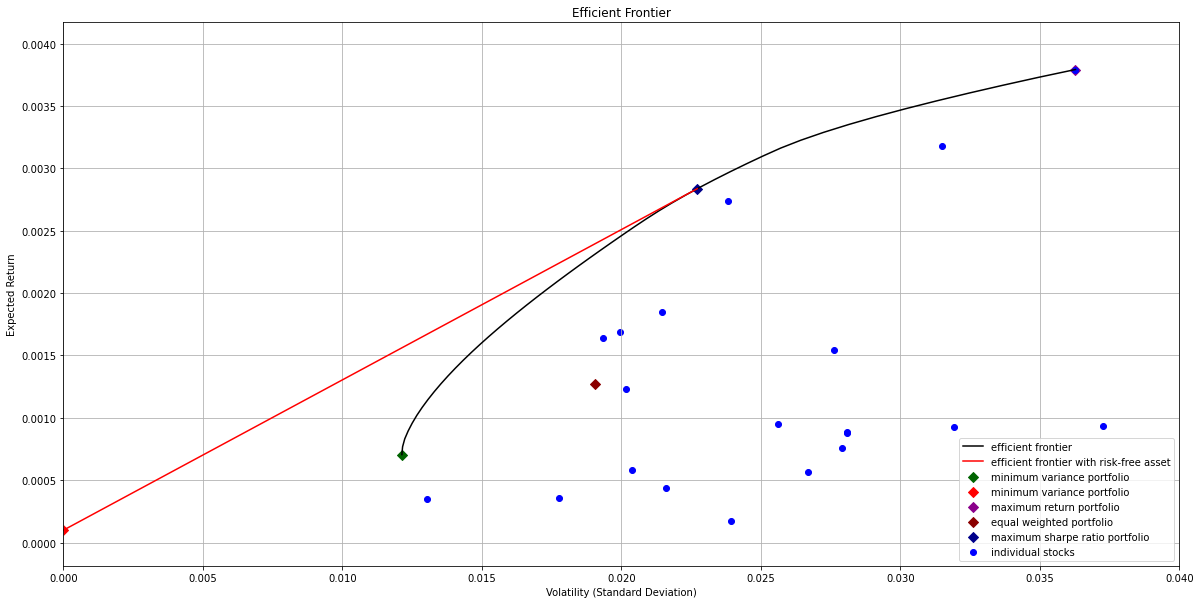

In [51]:
ax = plt.gca()
plt.rcParams['figure.figsize'] = (20,10)
    
# Plot volatility versus expected return for minimum variance portfolio
ax.scatter(x=np.sqrt(var_minVar), y=ret_minVar, marker='D', s=50,  color='DarkGreen', label='minimum variance portfolio')

# Plot volatility versus expected return for minimum variance portfolio with risk-free asset
ax.scatter(x=np.sqrt(var_minVar_r), y=ret_minVar_r, marker='D', s=50,  color='Red', label='minimum variance portfolio')

# Plot volatility versus expected return for maximum return portfolio
ax.scatter(x=np.sqrt(var_maxRet), y=ret_maxRet,  marker='D', s=50, color='DarkMagenta', label='maximum return portfolio')

# Plot volatility versus expected return for equal weighted portfolio
ax.scatter(x=np.sqrt(var_equal), y=ret_equal,  marker='D', s=50, color='DarkRed', label='equal weighted portfolio')

# Plot volatility versus expected return for maximum sharpe ratio portfolio
ax.scatter(x=np.sqrt(var_maxSha), y=ret_maxSha,  marker='D', s=50, color='DarkBlue', label='maximum sharpe ratio portfolio')

# Plot efficient frontier without risk-free asset
ax.plot(np.sqrt(var_front), ret_front, 'k-', label='efficient frontier')

# Plot efficient frontier with risk-free asset
point1 = [np.sqrt(var_minVar_r), ret_minVar_r]
point2 = [np.sqrt(var_maxSha), ret_maxSha]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
ax.plot(x_values, y_values, 'k-', label='efficient frontier with risk-free asset', color='Red')

# Plot volatility versus expected return for individual stocks
ax.scatter(x=np.sqrt(np.diag(Q)), y=mu, color='Blue', label='individual stocks')

# Format and display the final plot
ax.axis([0.9*np.sqrt(var_minVar), 1.2*np.max(np.sqrt(np.diag(Q))), np.min(mu)-0.1*(np.max(mu)-np.min(mu)), 1.1*ret_maxRet])
ax.set_xlabel('Volatility (Standard Deviation)')
ax.set_ylabel('Expected Return')
plt.title('Efficient Frontier')
ax.legend(loc="lower right")
ax.grid()
ax.set_xlim([0, 0.04])
plt.show()

## Question 2 Part 2

In [99]:
# Set Seed for reproducibility
np.random.seed(0)

# Set n
n = 20

# Randomize a Numpy Array with 1000 x n array
rand_n = np.random.exponential(size=(1000,20))
rand_n.sum(axis=1)
rand_n

# # This is a 1000 x 1 array
onehundred_by_n = rand_n.transpose() / rand_n.sum(axis=1)
# This is now a n x 1000 array
n_by_onehundred = onehundred_by_n.transpose() 

# # Create a dataframe
df_1000 = pd.DataFrame(n_by_onehundred)
# # This sums each row
df_1000.sum(axis=1)
# # Show dataframe
df_1000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.034265,0.054072,0.039748,0.033891,0.023724,0.044696,0.024778,0.095730,0.142717,0.020821,0.067546,0.032405,0.036140,0.111863,0.003172,0.003925,0.000879,0.076957,0.064829,0.087842
1,0.165666,0.069160,0.026666,0.065338,0.005423,0.044007,0.006666,0.124702,0.031788,0.023074,0.013239,0.064119,0.026241,0.036205,0.000817,0.041420,0.040800,0.041341,0.123991,0.049337
2,0.031055,0.040048,0.083374,0.004330,0.076599,0.077414,0.016465,0.009621,0.026415,0.031514,0.058861,0.040242,0.310500,0.007503,0.016332,0.012262,0.073799,0.020359,0.043771,0.019537
3,0.009994,0.006751,0.061656,0.008585,0.012635,0.026555,0.099308,0.005896,0.105051,0.005832,0.216418,0.036502,0.217162,0.053598,0.077598,0.002308,0.019189,0.007392,0.020272,0.007296
4,0.027817,0.038879,0.004819,0.085711,0.060773,0.022418,0.053843,0.007171,0.062357,0.192565,0.027880,0.080017,0.010273,0.091580,0.024834,0.014708,0.064192,0.001476,0.128346,0.000342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.113741,0.013213,0.004681,0.033544,0.046049,0.022479,0.050430,0.053518,0.030759,0.057521,0.032688,0.020991,0.019156,0.017407,0.003144,0.014169,0.080455,0.233092,0.128232,0.024730
996,0.109893,0.058785,0.034857,0.022963,0.002752,0.073752,0.138272,0.039087,0.052125,0.005575,0.025111,0.030089,0.008119,0.053455,0.112142,0.033130,0.093703,0.046271,0.027878,0.032040
997,0.090297,0.002679,0.028341,0.077817,0.080845,0.017092,0.015194,0.121789,0.062528,0.035493,0.008149,0.046388,0.090131,0.024911,0.128836,0.011816,0.012117,0.005322,0.117132,0.023124
998,0.064122,0.031754,0.071324,0.038005,0.003303,0.024449,0.028423,0.017514,0.035868,0.006112,0.019460,0.135163,0.244080,0.030921,0.027534,0.031668,0.035496,0.029729,0.062443,0.062634


In [100]:
var_1000 = []
ret_1000 = []
for i in range(1000):
    w_1000 = np.array(df_1000.iloc[i])
    var_1000.append(np.dot(w_1000, np.dot(Q, w_1000)))
    ret_1000.append(np.dot(mu, w_1000))


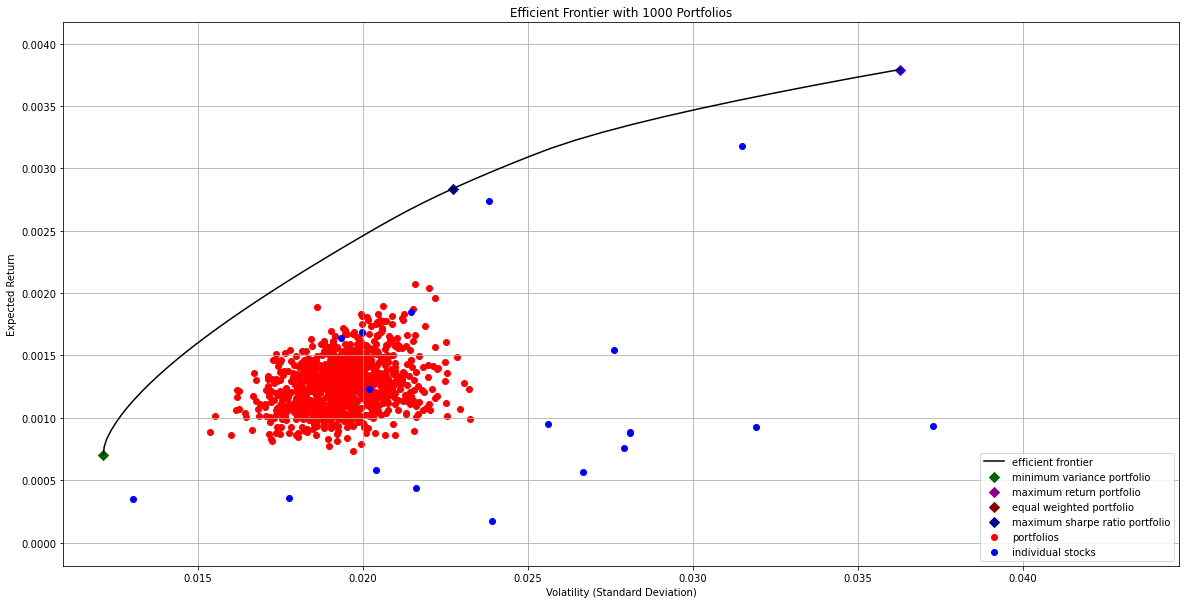

In [101]:
ax = plt.gca()
plt.rcParams['figure.figsize'] = (20,10)
    
# Plot volatility versus expected return for minimum variance portfolio
ax.scatter(x=np.sqrt(var_minVar), y=ret_minVar, marker='D', s=50,  color='DarkGreen', label='minimum variance portfolio')

# Plot volatility versus expected return for maximum return portfolio
ax.scatter(x=np.sqrt(var_maxRet), y=ret_maxRet,  marker='D', s=50, color='DarkMagenta', label='maximum return portfolio')

# Plot volatility versus expected return for equal weighted portfolio
ax.scatter(x=np.sqrt(var_equal), y=ret_equal,  marker='D', s=50, color='DarkRed', label='equal weighted portfolio')

# Plot volatility versus expected return for maximum sharpe ratio portfolio
ax.scatter(x=np.sqrt(var_maxSha), y=ret_maxSha,  marker='D', s=50, color='DarkBlue', label='maximum sharpe ratio portfolio')

# Plot efficient frontier
ax.plot(np.sqrt(var_front), ret_front, 'k-', label='efficient frontier')

# Plot volatility versus expected return for 1000 randomly generated portfolios
ax.scatter(x=np.sqrt(var_1000), y=ret_1000, color='Red', label='portfolios')

# Plot volatility versus expected return for individual stocks
ax.scatter(x=np.sqrt(np.diag(Q)), y=mu, color='Blue', label='individual stocks')

# Format and display the final plot
ax.axis([0.9*np.sqrt(var_minVar), 1.2*np.max(np.sqrt(np.diag(Q))), np.min(mu)-0.1*(np.max(mu)-np.min(mu)), 1.1*ret_maxRet])
ax.set_xlabel('Volatility (Standard Deviation)')
ax.set_ylabel('Expected Return')
plt.title('Efficient Frontier with 1000 Portfolios')
ax.legend(loc="lower right")
ax.grid()
plt.show()

## Question 3 Part 1

In [38]:
# Import FF models data from 2019-01-03 to 2020-12-31
input_file_factors  = 'Daily_FF_factors.csv'
if path.exists(input_file_factors):
    print('\nReading daily FF factors datafile - {}\n'.format(input_file_factors))
    ff_data = pd.read_csv(input_file_factors)
    factors_name = list(ff_data.columns)[1:-1]
    rf      = ff_data['RF'][1:]
    factors = ff_data.values[1:,1:4]
else:
    print("No such file '{}'".format(input_file_factors), file=sys.stderr)

# Indicides helpful to seperate data
# dates[day_ind_start_2019] = '01/02/2019',
# dates[day_ind_end_2019] = '12/31/2019',
# dates[day_ind_start_2019] = '01/02/2020',
# dates[day_ind_end_2019] = '12/31/2019'.
day_ind_start_2019 = 0
day_ind_end_2019   = 251
day_ind_start_2020 = 252
day_ind_end_2020   = 504

data_prices_2019   = data_prices[day_ind_start_2019:day_ind_end_2019+1]
data_prices_2020   = data_prices[day_ind_start_2020:day_ind_end_2020+1]
print(len(data_prices_2019))
print(len(data_prices_2020))


Reading daily FF factors datafile - Daily_FF_factors.csv

252
253


In [39]:
# Read Daily Prices
# CSV file with price data
input_file_prices  = 'Daily_closing_prices.csv'
# Read data into a dataframe
df = pd.read_csv(input_file_prices)

### Daily Assets Returns

In [40]:
df3 = pd.DataFrame(columns=df.columns.values[1:])
for column in df.columns.values[1:]:
    df3[column] = df[column].pct_change()

df3 = df3.iloc[1:]
df3

,MSFT,F,JPM,GOOG,HPQ,C,HOG,VZ,AAPL,IBM,T,CSCO,BAC,INTC,AMD,SNE,NVDA,AMZN,MS,BK
1,-0.036788,-0.015190,-0.014212,-0.028484,-0.033931,-0.018121,-0.027582,0.003570,-0.099607,-0.019964,0.001354,-0.036368,-0.016026,-0.055013,-0.094530,-0.034893,-0.060417,-0.025242,-0.017822,-0.019790
2,0.046509,0.038560,0.036866,0.053786,0.039639,0.048897,0.046470,0.002490,0.042689,0.039058,0.025693,0.045045,0.041531,0.061362,0.114370,0.046576,0.064068,0.050064,0.040827,0.028995
3,0.001275,0.025990,0.000695,-0.002167,0.011100,0.008707,0.029700,0.006387,-0.002226,0.007075,0.018128,0.006757,-0.000782,0.004659,0.082632,0.010364,0.052941,0.034353,0.009927,-0.002296
4,0.007251,0.009650,-0.001886,0.007385,0.012410,-0.002697,0.020162,0.029267,0.019063,0.014219,0.012626,0.008100,-0.001956,0.006324,0.008751,0.003419,-0.024895,0.016612,-0.006234,-0.003766
5,0.014300,0.041816,-0.001690,-0.001505,0.000000,0.016589,0.001372,-0.012583,0.016982,0.007177,-0.021775,-0.005510,0.009800,0.005655,-0.026988,0.000802,0.019667,0.001714,0.006997,0.002940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,0.007827,-0.014461,-0.004398,0.003735,0.002065,-0.003455,-0.011718,-0.002035,0.007712,0.006376,-0.002087,0.003605,-0.002995,0.010737,0.002840,-0.006362,-0.001191,-0.003949,-0.001759,0.001464
501,0.009921,0.003386,0.006585,0.021416,0.000412,0.009246,-0.000270,0.002379,0.035766,0.001043,-0.004880,0.008532,0.005674,0.000000,-0.002287,0.011462,-0.007215,0.035071,-0.000587,0.009747
502,-0.003601,-0.007874,-0.002633,-0.009780,-0.009065,-0.003599,-0.017251,-0.002882,-0.013315,-0.008172,-0.000350,-0.006233,-0.003983,0.049288,-0.010699,0.025319,0.003353,0.011584,-0.004996,0.000000
503,-0.011019,0.004535,0.002800,-0.010917,0.011227,-0.000821,0.015085,-0.011393,-0.008527,0.004362,-0.001752,-0.003584,-0.001000,-0.012958,0.018429,0.003485,0.015645,-0.010882,0.001920,0.006033


### Assets Excess Returns

In [41]:
for column in df3.columns.values:
    df3[column] = df3[column]-rf

df3

,MSFT,F,JPM,GOOG,HPQ,C,HOG,VZ,AAPL,IBM,T,CSCO,BAC,INTC,AMD,SNE,NVDA,AMZN,MS,BK
1,-0.046788,-0.025190,-0.024212,-0.038484,-0.043931,-0.028121,-0.037582,-0.006430,-0.109607,-0.029964,-0.008646,-0.046368,-0.026026,-0.065013,-0.104530,-0.044893,-0.070417,-0.035242,-0.027822,-0.029790
2,0.036509,0.028560,0.026866,0.043786,0.029639,0.038897,0.036470,-0.007510,0.032689,0.029058,0.015693,0.035045,0.031531,0.051362,0.104370,0.036576,0.054068,0.040064,0.030827,0.018995
3,-0.008725,0.015990,-0.009305,-0.012167,0.001100,-0.001293,0.019700,-0.003613,-0.012226,-0.002925,0.008128,-0.003243,-0.010782,-0.005341,0.072632,0.000364,0.042941,0.024353,-0.000073,-0.012296
4,-0.002749,-0.000350,-0.011886,-0.002615,0.002410,-0.012697,0.010162,0.019267,0.009063,0.004219,0.002626,-0.001900,-0.011956,-0.003676,-0.001249,-0.006581,-0.034895,0.006612,-0.016234,-0.013766
5,0.004300,0.031816,-0.011690,-0.011505,-0.010000,0.006589,-0.008628,-0.022583,0.006982,-0.002823,-0.031775,-0.015510,-0.000200,-0.004345,-0.036988,-0.009198,0.009667,-0.008286,-0.003003,-0.007060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,0.007827,-0.014461,-0.004398,0.003735,0.002065,-0.003455,-0.011718,-0.002035,0.007712,0.006376,-0.002087,0.003605,-0.002995,0.010737,0.002840,-0.006362,-0.001191,-0.003949,-0.001759,0.001464
501,0.009921,0.003386,0.006585,0.021416,0.000412,0.009246,-0.000270,0.002379,0.035766,0.001043,-0.004880,0.008532,0.005674,0.000000,-0.002287,0.011462,-0.007215,0.035071,-0.000587,0.009747
502,-0.003601,-0.007874,-0.002633,-0.009780,-0.009065,-0.003599,-0.017251,-0.002882,-0.013315,-0.008172,-0.000350,-0.006233,-0.003983,0.049288,-0.010699,0.025319,0.003353,0.011584,-0.004996,0.000000
503,-0.011019,0.004535,0.002800,-0.010917,0.011227,-0.000821,0.015085,-0.011393,-0.008527,0.004362,-0.001752,-0.003584,-0.001000,-0.012958,0.018429,0.003485,0.015645,-0.010882,0.001920,0.006033


### Merge Excess Return Data with 3-Factors Data

In [42]:
# Merging the data
all_data = pd.merge(pd.DataFrame(df3),ff_data, how = 'inner', left_index= True, right_index= True)
# Rename the columns
all_data.rename(columns={"Mkt-RF":"mkt_excess"}, inplace=True)
all_data = all_data.drop(columns=['Unnamed: 0'])
all_data

,MSFT,F,JPM,GOOG,HPQ,C,HOG,VZ,AAPL,IBM,...,AMD,SNE,NVDA,AMZN,MS,BK,mkt_excess,SMB,HML,RF
1,-0.046788,-0.025190,-0.024212,-0.038484,-0.043931,-0.028121,-0.037582,-0.006430,-0.109607,-0.029964,...,-0.104530,-0.044893,-0.070417,-0.035242,-0.027822,-0.029790,-2.45,0.40,1.21,0.01
2,0.036509,0.028560,0.026866,0.043786,0.029639,0.038897,0.036470,-0.007510,0.032689,0.029058,...,0.104370,0.036576,0.054068,0.040064,0.030827,0.018995,3.55,0.41,-0.70,0.01
3,-0.008725,0.015990,-0.009305,-0.012167,0.001100,-0.001293,0.019700,-0.003613,-0.012226,-0.002925,...,0.072632,0.000364,0.042941,0.024353,-0.000073,-0.012296,0.94,0.97,-0.77,0.01
4,-0.002749,-0.000350,-0.011886,-0.002615,0.002410,-0.012697,0.010162,0.019267,0.009063,0.004219,...,-0.001249,-0.006581,-0.034895,0.006612,-0.016234,-0.013766,1.01,0.53,-0.64,0.01
5,0.004300,0.031816,-0.011690,-0.011505,-0.010000,0.006589,-0.008628,-0.022583,0.006982,-0.002823,...,-0.036988,-0.009198,0.009667,-0.008286,-0.003003,-0.007060,0.56,0.45,0.09,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,0.007827,-0.014461,-0.004398,0.003735,0.002065,-0.003455,-0.011718,-0.002035,0.007712,0.006376,...,0.002840,-0.006362,-0.001191,-0.003949,-0.001759,0.001464,0.21,-0.39,-0.17,0.00
501,0.009921,0.003386,0.006585,0.021416,0.000412,0.009246,-0.000270,0.002379,0.035766,0.001043,...,-0.002287,0.011462,-0.007215,0.035071,-0.000587,0.009747,0.46,-0.72,0.32,0.00
502,-0.003601,-0.007874,-0.002633,-0.009780,-0.009065,-0.003599,-0.017251,-0.002882,-0.013315,-0.008172,...,-0.010699,0.025319,0.003353,0.011584,-0.004996,0.000000,-0.40,-1.52,0.24,0.00
503,-0.011019,0.004535,0.002800,-0.010917,0.011227,-0.000821,0.015085,-0.011393,-0.008527,0.004362,...,0.018429,0.003485,0.015645,-0.010882,0.001920,0.006033,0.27,0.99,0.04,0.00


### Fit Models using OLS Regression

In [43]:
# Period 1 R-squared
# store r-squared values
s1 = []
# store factor loadings values
f1 = []
# 2019
period_1 = all_data.iloc[:251]
X_1 = all_data[['mkt_excess', 'SMB', 'HML']].iloc[:251]
X_1 = smf.add_constant(X_1).astype(float)
for column in period_1.columns.values[:20]:
    y = period_1[column]
    model = smf.OLS(y, X_1)
    result = model.fit()
    s1.append(result.rsquared)
    f1.append([result.params[0],result.params[1],result.params[2],result.params[3]])

# Period 2 R-squared
# store r-squared values
s2 = []
# store factor loadings values
f2 = []
# 2020
period_2 = all_data.iloc[251:504]
X_2 = all_data[['mkt_excess', 'SMB', 'HML']].iloc[251:504]
X_2 = smf.add_constant(X_2).astype(float)
for column in period_2.columns.values[:20]:
    y = period_2[column]
    model = smf.OLS(y, X_2)
    result = model.fit()
    s2.append(result.rsquared)
    f2.append([result.params[0],result.params[1],result.params[2],result.params[3]])

# Period 3 R-squared
# store r-squared values
s3 = []
# store factor loadings values
f3 = []
# two years
period_3 = all_data
X_3 = all_data[['mkt_excess', 'SMB', 'HML']]
X_3 = smf.add_constant(X_3).astype(float)
for column in period_3.columns.values[:20]:
    y = period_3[column]
    model = smf.OLS(y, X_3)
    result = model.fit()
    s3.append(result.rsquared)
    f3.append([result.params[0],result.params[1],result.params[2],result.params[3]])

### Factor Loadings: Mkt-RF, SMB, HML

### Factor Loadings in 2019

In [44]:
df_factor_1 = pd.DataFrame(f1, index=[all_data.columns.values[:20]],
                                      columns= ['constant','mkt_excess','SMB','HML'])
df_factor_1

,constant,mkt_excess,SMB,HML
MSFT,-0.008115,0.012480,-0.004860,-0.005243
F,-0.008120,0.010187,0.005505,0.005376
JPM,-0.007749,0.011368,-0.003083,0.009953
GOOG,-0.008755,0.011987,-0.000276,-0.004431
HPQ,-0.009278,0.012463,0.001341,0.002378
C,-0.007809,0.015404,-0.001497,0.010721
HOG,-0.008710,0.014426,0.004634,0.010641
VZ,-0.008317,0.003557,-0.002750,-0.000280
AAPL,-0.007416,0.014750,-0.001725,-0.002657
IBM,-0.008668,0.010820,-0.002796,0.001895


### Factor Loadings in 2020

In [45]:
df_factor_2 = pd.DataFrame(f2, index=[all_data.columns.values[:20]],
                                      columns= ['constant','mkt_excess','SMB','HML'])
df_factor_2

,constant,mkt_excess,SMB,HML
MSFT,-0.001585,0.012518,-0.002611,-0.005145
F,-0.000704,0.008952,0.001251,0.010016
JPM,-0.000619,0.010522,-0.002925,0.011202
GOOG,-0.001481,0.010161,-0.001256,-0.002577
HPQ,-0.001037,0.010593,0.007312,0.003554
C,-0.001043,0.012899,-0.000314,0.013294
HOG,-0.000712,0.013514,0.003191,0.008999
VZ,-0.001610,0.005099,-0.002851,0.001182
AAPL,-0.000369,0.012392,-0.004116,-0.004339
IBM,-0.001723,0.009247,-0.000530,0.003232


### Factor Loadings in 2019-2020

In [46]:
df_factor_3 = pd.DataFrame(f3, index=[all_data.columns.values[:20]],
                                      columns= ['constant','mkt_excess','SMB','HML'])
df_factor_3

,constant,mkt_excess,SMB,HML
MSFT,-0.004818,0.012503,-0.002833,-0.005240
F,-0.004436,0.009341,0.002752,0.009034
JPM,-0.004158,0.010692,-0.002539,0.010818
GOOG,-0.005081,0.010496,-0.000499,-0.003147
HPQ,-0.005003,0.010821,0.006537,0.003249
C,-0.004329,0.013317,0.000015,0.012657
HOG,-0.004725,0.013625,0.003922,0.008913
VZ,-0.005008,0.004959,-0.002654,0.000951
AAPL,-0.003882,0.012705,-0.003073,-0.004534
IBM,-0.005112,0.009488,-0.000553,0.002850


### R-squared Value in 2019, 2020, and 2019-2020

In [47]:
numpy_array = np.array([s1,s2,s3])
numpy_array

# Create a dataframe that contains R-squared
df_r = pd.DataFrame(numpy_array, index=['2019', '2020', '2019-2020'],
                                 columns=[all_data.columns.values[:20]])
df_r

,MSFT,F,JPM,GOOG,HPQ,C,HOG,VZ,AAPL,IBM,T,CSCO,BAC,INTC,AMD,SNE,NVDA,AMZN,MS,BK
2019,0.733782,0.322942,0.737760,0.468008,0.27425,0.762388,0.489308,0.081453,0.544906,0.445746,0.186319,0.438211,0.720136,0.374959,0.395763,0.297078,0.505823,0.574535,0.692871,0.414714
2020,0.880915,0.646845,0.887034,0.752131,0.60674,0.870422,0.562520,0.547254,0.763396,0.723068,0.734615,0.658981,0.898552,0.576326,0.530567,0.560851,0.788277,0.591290,0.842146,0.754778
2019-2020,0.836645,0.571292,0.854627,0.650872,0.51071,0.846797,0.545291,0.380165,0.693281,0.648105,0.606403,0.585631,0.858923,0.527248,0.442763,0.434783,0.668146,0.555235,0.799401,0.677046


### Question 3 Part 2

In [ ]:
np.random.seed(1)
numPaths = 100
numSteps = 504

# Read matrix of correlations for credit drivers
rho = np.array([[2.6999, 0.1351, 0.4893],
                [0.1351, 0.5005, 0.217],
                [0.4893, 0.217,  1.479]])
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

### 1-day VaR for 100 MSFT

In [128]:
var_list = []

for p in range(numPaths):
    PLData = []
    value = data_prices[0,0]*100   
    for i in range(numSteps):        
        normal_random_vector = np.random.randn(3,1)
        array = np.dot(sqrt_rho, normal_random_vector).T
        f1, f2, f3 = array[0][0], array[0][1], array[0][2]
        # compute return rate
        r_i = rf[i] + df_factor_3.loc['MSFT']['constant'] + f1*df_factor_3.loc['MSFT']['mkt_excess'] + f2*df_factor_3.loc['MSFT']['SMB'] + f3*df_factor_3.loc['MSFT']['HML']
        PL_i = r_i*value
        PLData.append(PL_i)
        value = value + PL_i
    loss = np.sort(-np.array(PLData))
    N = len(PLData)
    VaR = loss[int(math.ceil(N * alf)) - 1]
    var_list.append(VaR)

var_MSFT = np.array(var_list).mean()

### 1-day VaRn for MSFT

In [129]:
var_list = []

for p in range(numPaths):
    PLData = []
    value = data_prices[0,0]*100   
    for i in range(numSteps):        
        normal_random_vector = np.random.randn(3,1)
        array = np.dot(sqrt_rho, normal_random_vector).T
        f1, f2, f3 = array[0][0], array[0][1], array[0][2]
        # compute return rate
        r_i = rf[i] + df_factor_3.loc['MSFT']['constant'] + f1*df_factor_3.loc['MSFT']['mkt_excess'] + f2*df_factor_3.loc['MSFT']['SMB'] + f3*df_factor_3.loc['MSFT']['HML']
        PL_i = r_i*value
        PLData.append(PL_i)
        value = value + PL_i
    loss = np.sort(-np.array(PLData))
    N = len(PLData)
    VaRn = np.mean(loss) + scs.norm.ppf(alf) * np.std(loss)
    var_list.append(VaRn)

varn_MSFT = np.array(var_list).mean()

### 1-day VaR for 200 AAPL

In [104]:
var_list = []

for p in range(numPaths):
    PLData = []
    value = data_prices[0,8]*200   
    for i in range(numSteps):        
        normal_random_vector = np.random.randn(3,1)
        array = np.dot(sqrt_rho, normal_random_vector).T
        f1, f2, f3 = array[0][0], array[0][1], array[0][2]
        # compute return rate
        r_i = rf[i] + df_factor_3.loc['AAPL']['constant'] + f1*df_factor_3.loc['AAPL']['mkt_excess'] + f2*df_factor_3.loc['AAPL']['SMB'] + f3*df_factor_3.loc['AAPL']['HML']
        PL_i = r_i*value
        PLData.append(PL_i)
        value = value + PL_i
    loss = np.sort(-np.array(PLData))
    N = len(PLData)
    VaR = loss[int(math.ceil(N * alf)) - 1]
    var_list.append(VaR)

var_AAPL = np.array(var_list).mean()

### 1-day VaRn for 200 AAPL

In [105]:
var_list = []

for p in range(numPaths):
    PLData = []
    value = data_prices[0,8]*200   
    for i in range(numSteps):        
        normal_random_vector = np.random.randn(3,1)
        array = np.dot(sqrt_rho, normal_random_vector).T
        f1, f2, f3 = array[0][0], array[0][1], array[0][2]
        # compute return rate
        r_i = rf[i] + df_factor_3.loc['AAPL']['constant'] + f1*df_factor_3.loc['AAPL']['mkt_excess'] + f2*df_factor_3.loc['AAPL']['SMB'] + f3*df_factor_3.loc['AAPL']['HML']
        PL_i = r_i*value
        PLData.append(PL_i)
        value = value + PL_i
    loss = np.sort(-np.array(PLData))
    N = len(PLData)
    VaRn = np.mean(loss) + scs.norm.ppf(alf) * np.std(loss)
    var_list.append(VaRn)

varn_AAPL = np.array(var_list).mean()

### 1-day VaR for 500 IBM

In [106]:
var_list = []

for p in range(numPaths):
    PLData = []
    value = data_prices[0,9]*500   
    for i in range(numSteps):        
        normal_random_vector = np.random.randn(3,1)
        array = np.dot(sqrt_rho, normal_random_vector).T
        f1, f2, f3 = array[0][0], array[0][1], array[0][2]
        # compute return rate
        r_i = rf[i] + df_factor_3.loc['IBM']['constant'] + f1*df_factor_3.loc['IBM']['mkt_excess'] + f2*df_factor_3.loc['IBM']['SMB'] + f3*df_factor_3.loc['IBM']['HML']
        PL_i = r_i*value
        PLData.append(PL_i)
        value = value + PL_i
    loss = np.sort(-np.array(PLData))
    N = len(PLData)
    VaR = loss[int(math.ceil(N * alf)) - 1]
    var_list.append(VaR)

var_IBM = np.array(var_list).mean()

### 1-day VaRn for 500 IBM

In [107]:
var_list = []

for p in range(numPaths):
    PLData = []
    value = data_prices[0,9]*500   
    for i in range(numSteps):        
        normal_random_vector = np.random.randn(3,1)
        array = np.dot(sqrt_rho, normal_random_vector).T
        f1, f2, f3 = array[0][0], array[0][1], array[0][2]
        # compute return rate
        r_i = rf[i] + df_factor_3.loc['IBM']['constant'] + f1*df_factor_3.loc['IBM']['mkt_excess'] + f2*df_factor_3.loc['IBM']['SMB'] + f3*df_factor_3.loc['IBM']['HML']
        # increased value for 500 IBM
        PL_i = r_i*value
        PLData.append(PL_i)
        value = value + PL_i
    loss = np.sort(-np.array(PLData))
    N = len(PLData)
    VaRn = np.mean(loss) + scs.norm.ppf(alf) * np.std(loss)
    var_list.append(VaRn)

varn_IBM = np.array(var_list).mean()

### 1-day VaR for Portfolio

In [123]:
var_list = []

for p in range(numPaths):
    PLData = []
    value_m = data_prices[0,0]*100 
    value_a = data_prices[0,8]*200 
    value_i = data_prices[0,9]*500 
    for i in range(numSteps):        
        normal_random_vector = np.random.randn(3,1)
        array = np.dot(sqrt_rho, normal_random_vector).T
        f1, f2, f3 = array[0][0], array[0][1], array[0][2]
        # Return rate for MSFT
        r_m = rf[i] + df_factor_3.loc['MSFT']['constant'] + f1*df_factor_3.loc['MSFT']['mkt_excess'] + f2*df_factor_3.loc['MSFT']['SMB'] + f3*df_factor_3.loc['MSFT']['HML']
        PL_m = r_m*value_m
        # Return rate for AAPL
        r_a = rf[i] + df_factor_3.loc['AAPL']['constant'] + f1*df_factor_3.loc['AAPL']['mkt_excess'] + f2*df_factor_3.loc['AAPL']['SMB'] + f3*df_factor_3.loc['AAPL']['HML']
        PL_a = r_a*value_a
        # Return rate for IBM
        r_i = rf[i] + df_factor_3.loc['IBM']['constant'] + f1*df_factor_3.loc['IBM']['mkt_excess'] + f2*df_factor_3.loc['IBM']['SMB'] + f3*df_factor_3.loc['IBM']['HML']        
        PL_i = r_i*value_i
        temp = np.array(PL_m) + np.array(PL_a) + np.array(PL_i)
        # Append increased portfolio value
        PLData.append(temp)
        # Update the portfolio value
        value_m, value_a, value_i = value_m + PL_m, value_a + PL_a, value_i + PL_i
    loss = np.sort(-np.array(PLData))
    N = len(PLData)
    VaR = loss[int(math.ceil(N * alf)) - 1]
    var_list.append(VaR)

var_portfolio = np.array(var_list).mean()

### 1-day VaRn for Portfolio

In [122]:
var_list = []

for p in range(numPaths):
    PLData = []
    value_m = data_prices[0,0]*100 
    value_a = data_prices[0,8]*200 
    value_i = data_prices[0,9]*500 
    for i in range(numSteps):        
        normal_random_vector = np.random.randn(3,1)
        array = np.dot(sqrt_rho, normal_random_vector).T
        f1, f2, f3 = array[0][0], array[0][1], array[0][2]
        # Return rate for MSFT
        r_m = rf[i] + df_factor_3.loc['MSFT']['constant'] + f1*df_factor_3.loc['MSFT']['mkt_excess'] + f2*df_factor_3.loc['MSFT']['SMB'] + f3*df_factor_3.loc['MSFT']['HML']
        PL_m = r_m * value_m
        # Return rate for AAPL
        r_a = rf[i] + df_factor_3.loc['AAPL']['constant'] + f1*df_factor_3.loc['AAPL']['mkt_excess'] + f2*df_factor_3.loc['AAPL']['SMB'] + f3*df_factor_3.loc['AAPL']['HML']
        PL_a = r_a * value_a
        # Return rate for IBM
        r_i = rf[i] + df_factor_3.loc['IBM']['constant'] + f1*df_factor_3.loc['IBM']['mkt_excess'] + f2*df_factor_3.loc['IBM']['SMB'] + f3*df_factor_3.loc['IBM']['HML']        
        PL_i = r_i * value_i
        temp = np.array(PL_m) + np.array(PL_a) + np.array(PL_i)
        # Append increased portfolio value
        PLData.append(temp)
        # Update the portfolio value
        value_m, value_a, value_i = value_m + PL_m, value_a + PL_a, value_i + PL_i
    loss = np.sort(-np.array(PLData))
    N = len(PLData)
    VaRn = np.mean(loss) + scs.norm.ppf(alf) * np.std(loss)
    var_list.append(VaRn)

varn_portfolio = np.array(var_list).mean()

In [135]:
print('Historical Monte Carlo Simulation 1-day 100 MSFT VaR %4.1f%% = $%6.2f'% (100*alf, var_MSFT))
print('Historical Monte Carlo Simulation 1-day 200 AAPL VaR %4.1f%% = $%6.2f'% (100*alf, var_AAPL))
print('Historical Monte Carlo Simulation 1-day 500 IBM VaR %4.1f%% = $%6.2f'% (100*alf, var_IBM))
print('Historical Monte Carlo Simulation 1-day Sum of Individual Stocks VaR %4.1f%% = $%6.2f'% (100*alf, var_MSFT+var_AAPL+var_IBM))

print('Historical Monte Carlo Simulation 1-day Portfolio VaR %4.1f%% = $%6.2f'% (100*alf, var_portfolio))

var_portfolio - (var_MSFT+var_AAPL+var_IBM)

Historical Monte Carlo Simulation 1-day 100 MSFT VaR 95.0% = $ 68.71
Historical Monte Carlo Simulation 1-day 200 AAPL VaR 95.0% = $100.51
Historical Monte Carlo Simulation 1-day 500 IBM VaR 95.0% = $381.87
Historical Monte Carlo Simulation 1-day Sum of Individual Stocks VaR 95.0% = $551.09
Historical Monte Carlo Simulation 1-day Portfolio VaR 95.0% = $409.18


-141.90600688271417

In [134]:
print('Normal Monte Carlo Simulation 1-day 100 MSFT VaR %4.1f%% = $%6.2f'% (100*alf, varn_MSFT))
print('Normal Monte Carlo Simulation 1-day 200 AAPL VaR %4.1f%% = $%6.2f'% (100*alf, varn_AAPL))
print('Normal Monte Carlo Simulation 1-day 500 IBM VaR %4.1f%% = $%6.2f'% (100*alf, varn_IBM))
print('Normal Monte Carlo Simulation 1-day Sum of Individual Stocks VaR %4.1f%% = $%6.2f'% (100*alf, varn_MSFT+varn_AAPL+varn_IBM))

print('Normal Monte Carlo Simulation 1-day Portfolio VaR %4.1f%% = $%6.2f'% (100*alf, varn_portfolio))

varn_portfolio - (varn_MSFT+varn_AAPL+varn_IBM)

Normal Monte Carlo Simulation 1-day 100 MSFT VaR 95.0% = $629.94
Normal Monte Carlo Simulation 1-day 200 AAPL VaR 95.0% = $642.58
Normal Monte Carlo Simulation 1-day 500 IBM VaR 95.0% = $2626.11
Normal Monte Carlo Simulation 1-day Sum of Individual Stocks VaR 95.0% = $3898.63
Normal Monte Carlo Simulation 1-day Portfolio VaR 95.0% = $3906.46


7.836799858504037